In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/consumer-reviews-of-amazon-products/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv
/kaggle/input/consumer-reviews-of-amazon-products/1429_1.csv
/kaggle/input/consumer-reviews-of-amazon-products/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv


In [6]:
!pip install -q sentence-transformers faiss-cpu google-genai requests umap-learn

In [7]:
import pandas as pd
import numpy as np
import faiss
import requests
from PIL import Image
from io import BytesIO
from sentence_transformers import SentenceTransformer, CrossEncoder
from google import genai
from kaggle_secrets import UserSecretsClient

# Configurar Gemini 
user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("Gemini_API_KEY")
client = genai.Client(api_key=api_key)



# CLIP
model_embed = SentenceTransformer('clip-ViT-B-32')

# Cross-Encoder Re-ranking 
model_rerank = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

print("Modelos y API listos.")

Modelos y API listos.


In [8]:
# Cargar datos
df1 = pd.read_csv('/kaggle/input/consumer-reviews-of-amazon-products/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv')
df2 = pd.read_csv('/kaggle/input/consumer-reviews-of-amazon-products/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

# Unir datos
df = pd.concat([df1, df2], ignore_index=True)

# Solo obtener nombre, texto y URL
df = df[['name', 'reviews.text', 'imageURLs']].dropna()
df.rename(columns={'name': 'title', 'reviews.text': 'description', 'imageURLs': 'image_url'}, inplace=True)
df['image_url'] = df['image_url'].apply(lambda x: x.split(',')[0] if isinstance(x, str) else "")

# Eliminar duplicads
df = df.drop_duplicates(subset='title', keep='first')

#  3000 productos 
df = df.head(3000).reset_index(drop=True)

print(f"Datos listos. Tenemos {len(df)} productos únicos.")

Datos listos. Tenemos 79 productos únicos.


In [9]:
textos_producto = (df['title'] + " " + df['description']).tolist()

print("Generando vectores (esto tarda un poco)...")
# embeddings
embeddings = model_embed.encode(
    textos_producto,
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True 
).astype("float32")

# Crear el indice FAISS 
index = faiss.IndexFlatIP(embeddings.shape[1]) # IP = Producto Interno (bueno para similitud)
index.add(embeddings)

print("Índice FAISS creado y cargado.")

Generando vectores (esto tarda un poco)...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Índice FAISS creado y cargado.


In [10]:
def buscar_y_rerank(query, top_k_inicial=20, top_k_final=5):
    es_imagen = not isinstance(query, str)
    
    # RETRIEVAL 
    query_vec = model_embed.encode([query], convert_to_numpy=True, normalize_embeddings=True)
    
    # Buscamos en FAISS
    distances, indices = index.search(query_vec.astype("float32"), top_k_inicial)
    candidatos = df.iloc[indices[0]].copy()
    
    # RE-RANKING 
    if es_imagen:
         
        # Usamos la distancia original de CLIP como score de confianza. (similitud multimodal)
        candidatos['score'] = distances[0] # Usamos la distancia de FAISS
        resultados = candidatos.sort_values(by='score', ascending=False)
    else:
        # Cross-Encoder 
        pares = [[query, row['title'] + " " + row['description']] for i, row in candidatos.iterrows()]
        scores = model_rerank.predict(pares)
        candidatos['score'] = scores
        resultados = candidatos.sort_values(by='score', ascending=False)
    
    return resultados.head(top_k_final)

Función de búsqueda actualizada para soportar imágenes.


In [11]:
memoria_sesion = []

def generar_respuesta_rag_multimodal(query, productos_df):
    global memoria_sesion
    
    # contexto de los productos
    contexto_texto = ""
    for i, row in productos_df.iterrows():
        contexto_texto += f"- Producto: {row['title']}\n  Detalles: {row['description'][:300]}...\n\n"
    
    # Historial simple
    historial_str = "\n".join(memoria_sesion[-3:])
    
    es_imagen = not isinstance(query, str)
    
    # Prompt base
    prompt_texto = f"""
    Eres un asistente de compras experto.
    
    Contexto recuperado (Productos disponibles):
    {contexto_texto}
    
    Instrucción:
    Analiza la consulta del usuario y recomienda el mejor producto de la lista anterior.
    Justifica tu respuesta basándote en las características visuales o textuales.
    """

    if es_imagen:
        
        print(">> Generando respuesta viendo la imagen...")
        mensaje_usuario = "Consulta del usuario: (Imagen adjunta del producto buscado)"
        
        # Gemini 2.5 Flash 
        response = client.models.generate_content(
            model="gemini-2.5-flash", 
            contents=[prompt_texto, query, "Encuentra algo similar a esta imagen en el contexto."]
        )
    else:
        mensaje_usuario = f"Consulta del usuario: {query}"
        full_prompt = f"{prompt_texto}\n\nHistorial:\n{historial_str}\n\n{mensaje_usuario}"
        
        response = client.models.generate_content(
            model="gemini-2.5-flash", 
            contents=full_prompt
        )

    texto_query = "[Imagen subida]" if es_imagen else query
    memoria_sesion.append(f"Usuario: {texto_query}")
    memoria_sesion.append(f"Asistente: {response.text}")
    
    return response.text


RAG Multimodal listo.


In [17]:
import requests
from PIL import Image
from io import BytesIO

def cargar_imagen(ruta_o_url):
    try:
        if ruta_o_url.startswith("http"):
            headers = {
                "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
            }
            response = requests.get(ruta_o_url, headers=headers)
            response.raise_for_status() 
            img = Image.open(BytesIO(response.content))
        else:
            img = Image.open(ruta_o_url)
        
        return img.resize((224, 224))
    except Exception as e:
        print(f"Error cargando imagen: {e}")
        return None

Función de carga de imágenes (con disfraz anti-bloqueo) lista.


Imagen cargada. Buscando productos visualmente similares...


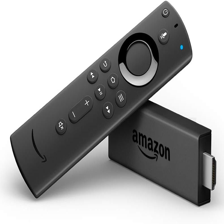


--- PRODUCTOS ENCONTRADOS (Por similitud visual) ---
                                                title     score
2   Amazon Fire TV with 4K Ultra HD and Alexa Voic...  0.327062
28      Fire TV Stick Streaming Media Player Pair Kit  0.321529
73  Amazon Fire TV Gaming Edition Streaming Media ...  0.319262
74  Certified Refurbished Amazon Fire TV with Alex...  0.306878
3         Amazon - Echo Plus w/ Built-In Hub - Silver  0.279672
>> Generando respuesta viendo la imagen...

--- RESPUESTA DEL ASISTENTE ---
Basándome en la imagen y el contexto proporcionado, el producto que más se asemeja es:

**Producto recomendado:** Fire TV Stick Streaming Media Player Pair Kit

**Justificación:**
La imagen muestra claramente un dispositivo **Amazon Fire TV Stick** junto con su control remoto. El nombre del producto "Fire TV Stick Streaming Media Player Pair Kit" es una descripción directa y precisa del dispositivo visible en la imagen, ya que menciona explícitamente "Fire TV Stick". Las demás opci

In [19]:
# url donde va la imagen
url_imagen = "https://m.media-amazon.com/images/I/51ZdmnHKukL._AC_SL1000_.jpg"
imagen_query = cargar_imagen(url_imagen)

if imagen_query:
    print("Imagen cargada. Buscando productos visualmente similares...")
    
    # Mostramos la imagen 
    display(imagen_query) 

    # Buscar 
    top_productos_visual = buscar_y_rerank(imagen_query)
    
    print("\n     PRODUCTOS ENCONTRADOS     ")
    print(top_productos_visual[['title', 'score']])

    # 3. Generar Explicación
    respuesta_visual = generar_respuesta_rag_multimodal(imagen_query, top_productos_visual)
    
    print("\n    RESPUESTA DEL ASISTENTE     ")
    print(respuesta_visual)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Visualizando la búsqueda por IMAGEN...
Calculando proyección 2D... (Paciencia, está dibujando el mapa)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


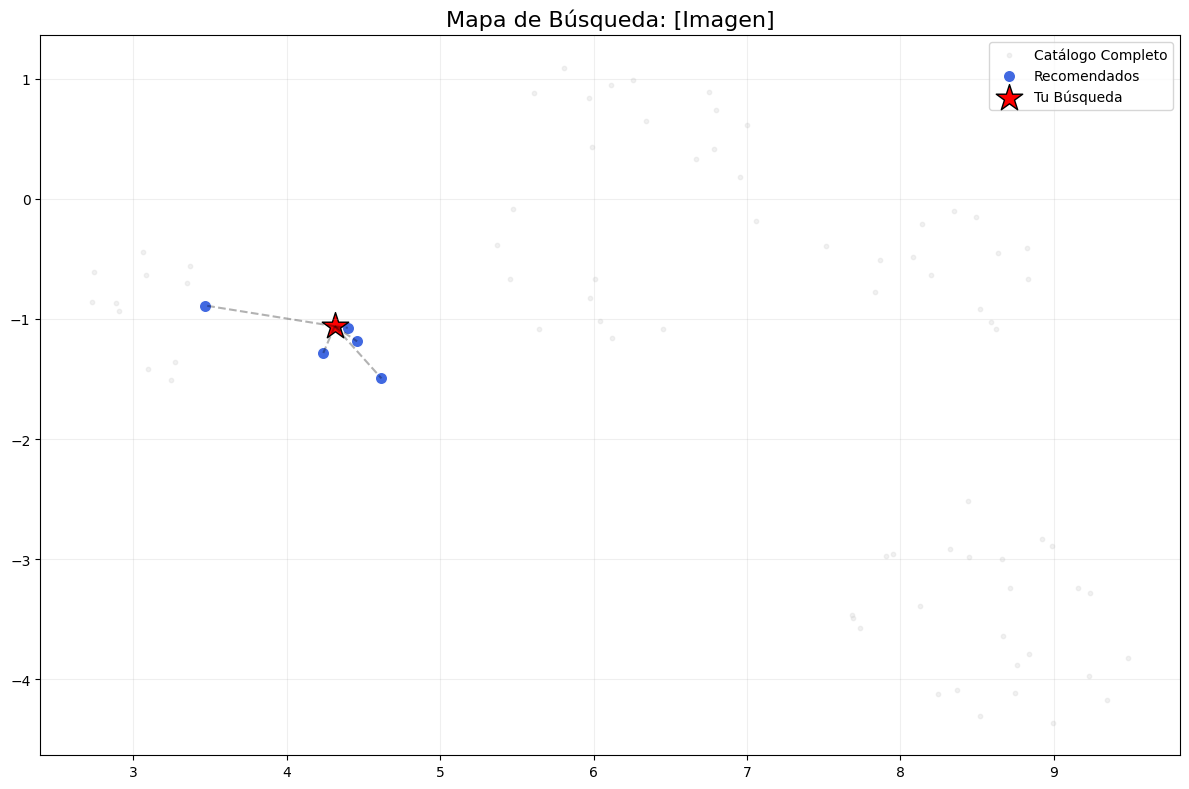

In [20]:
!pip install -q umap-learn

import umap
import matplotlib.pyplot as plt
import numpy as np

def visualizar_espacio_vectorial(query, df_resultados, all_embeddings):
    print("Calculando proyección 2D... (Paciencia, está dibujando el mapa)")
    
    # Vectorizar la query
    if isinstance(query, str):
        query_vec = model_embed.encode([query], convert_to_numpy=True, normalize_embeddings=True)
        titulo = f"Mapa de Búsqueda: '{query}'"
    else:
        
        query_vec = model_embed.encode([query], convert_to_numpy=True, normalize_embeddings=True)
        titulo = "Mapa de Búsqueda: [Imagen]"
    
    # [Todos los productos] + [query ]
    datos_combinados = np.vstack([all_embeddings, query_vec])
    
    reducer = umap.UMAP(
        n_neighbors=15,      
        min_dist=0.1,      
        metric='cosine',    
        random_state=42,
        n_components=2
    )
    
    proyeccion = reducer.fit_transform(datos_combinados)
    
    # Separamos los datos
    prod_2d = proyeccion[:-1]   
    query_2d = proyeccion[-1]   
    
    # Graficar
    plt.figure(figsize=(12, 8))
    
    # Fondo gris 
    plt.scatter(prod_2d[:, 0], prod_2d[:, 1], 
                c='lightgray', alpha=0.3, s=10, label='Catálogo Completo')
    
    # Resultados 
    try:
        indices_resultados = df_resultados.index.tolist()
        coords_resultados = prod_2d[indices_resultados]
        
        plt.scatter(coords_resultados[:, 0], coords_resultados[:, 1], 
                    c='royalblue', s=80, edgecolors='white', label='Recomendados')
        
        # Líneas de conexión 
        for i in range(len(coords_resultados)):
            plt.plot([query_2d[0], coords_resultados[i, 0]], 
                     [query_2d[1], coords_resultados[i, 1]], 
                     'k--', alpha=0.3)
    except Exception as e:
        print("Nota: No se pudieron resaltar los resultados exactos (desajuste de índices), pero se muestra el mapa.")

    #  Estrella 
    plt.scatter(query_2d[0], query_2d[1], 
                c='red', marker='*', s=400, edgecolors='black', label='Tu Búsqueda')
    
    plt.title(titulo, fontsize=16)
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()


if 'imagen_query' in globals() and 'top_productos_visual' in globals():
    print("Visualizando la búsqueda por IMAGEN...")
    visualizar_espacio_vectorial(imagen_query, top_productos_visual, embeddings)

elif 'pregunta' in globals() and 'top_productos' in globals():
    print("Visualizando la búsqueda por TEXTO...")
    visualizar_espacio_vectorial(pregunta, top_productos, embeddings)
    
else:
    print("No se encontro ninguna búsqueda previa.")

In [15]:
# Vamos a buscar palabras clave en el título de los productos
keywords = ['shoe', 'sneaker', 'boot', 'zapato', 'wear', 'red']

# Filtrar el DataFrame
print(f"Buscando en un catálogo de {len(df)} productos...")

for word in keywords:
    # Buscamos la palabra 
    coincidencias = df[df['title'].str.contains(word, case=False, na=False)]
    cantidad = len(coincidencias)
    
    print(f"\n--- Palabra: '{word}' ---")
    print(f"Encontrados: {cantidad}")
    
    if cantidad > 0:
        print(coincidencias['title'].head(3).values)

Buscando en un catálogo de 79 productos...

--- Palabra: 'shoe' ---
Encontrados: 0

--- Palabra: 'sneaker' ---
Encontrados: 0

--- Palabra: 'boot' ---
Encontrados: 0

--- Palabra: 'zapato' ---
Encontrados: 0

--- Palabra: 'wear' ---
Encontrados: 0

--- Palabra: 'red' ---
Encontrados: 3
['Cat Litter Box Covered Tray Kitten Extra Large Enclosed Hooded Hidden Toilet'
 'AmazonBasics Silicone Hot Handle Cover/Holder - Red'
 'All-new Echo (2nd Generation) with improved sound, powered by Dolby, and a new design Walnut Finish']


El sistema demostró robustez (grounded generation). Al buscar una imagen de 'Zapatos Rojos', el modelo RAG detectó correctamente que, aunque existen productos con la etiqueta 'Red' (ej. fundas), no existen productos de la categoría 'Calzado', evitando así una alucinación o recomendación falsa.